In [12]:
from cde_utility import *
import matplotlib.colors as colors
from numba import jit

## Dynamical Response

In [6]:
hbar = 6.626*10**(-34)/twopi
ev = 1.6*10**(-19)
c0 = 2.99792458*10**8
nm = 10**(-9)
d0 = 75*nm
a_o_d = 1.0/3.0
a0 = d0*a_o_d
# print(hbar, ev, c0, nm)

def eps_drude(w):
    w_pl = 11.34
    eps_a, eps_b, gamma = 5.45, 6.18, 0.05
    return eps_a - ( eps_b - eps_a )*w_pl**2 / w / (w + 1j*gamma)

def ev2kw( w, d ):
    return w*ev/hbar/c0/(twopi/d)

def kw2ev( kw, d ):
    return kw*twopi/d*c0*hbar/ev

In [7]:
# ev2kw(4.0, 75*nm)
# kw2ev( 0.25, 100*nm )

def alpha(kw, eps_func, a=25*nm, a_o_d=1.0/3.0, unit='twopi/d', rad_corr=True):
    eps = eps_func(kw)
    if unit == 'twopi/d':
        w = kw
    elif unit == 'eV':
        d = a / a_o_d
#         w = ev2kw( kw, d )
        w = kw*ev/hbar
    else:
        raise ValueError(r"Unit input is '{}'. ".format(unit)+\
                         r"Unit for kw must be 'twopi/d' or 'eV'!")
    pol = ( eps - 1.0 ) / ( eps + 2.0 ) * a**3
    if rad_corr:
        pol_inv = 1.0/pol - 1j*2.0/3.0*( w/c0 )**3
        pol = 1.0 / pol_inv
#         pol = 1.0 / ( 1.0/pol - 1j*2.0/3.0*( w*a_o_d*twopi )**3 )
    return pol

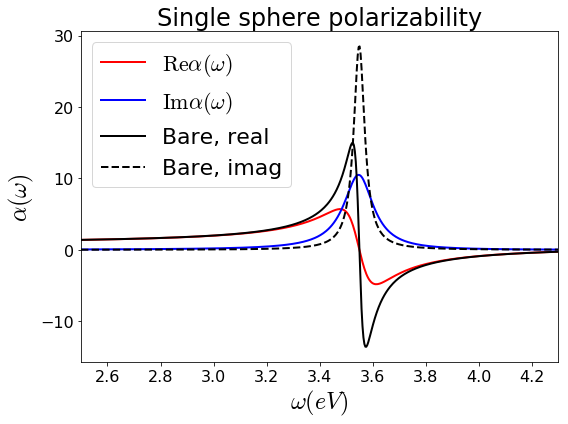

In [23]:
ws = np.linspace(2.5, 4.3, 501)
# epsw = eps_drude(ws)
# epsw = (epsw - 1)/(epsw+2)
# epsr = np.real(epsw)
# epsi = np.imag(epsw)
pol = alpha(ws, eps_drude, unit='eV', rad_corr=True)/a0**3
polr, poli = pol.real, pol.imag
pol_no_cor = alpha(ws, eps_drude, unit='eV', rad_corr=False)/a0**3
pol_no_r, pol_no_i = pol_no_cor.real, pol_no_cor.imag

plt.figure(figsize=(8,6))
# plt.plot(ws, epsr, 'ro-', label='$\mathrm{Re}\epsilon(\omega)$')
# plt.plot(ws, epsi, 'bo-', label='$\mathrm{Im}\epsilon(\omega)$')
plt.plot(ws, polr, 'r-', label=r'$\mathrm{Re}\alpha(\omega)$')
plt.plot(ws, poli, 'b-', label=r'$\mathrm{Im}\alpha(\omega)$')
axes = plt.gca()
ymin, ymax = axes.get_ylim()
# plt.vlines(3.57, ymin, ymax, color='k', linestyles='dashed')
plt.plot(ws, pol_no_r, 'k-', label='Bare, real')
plt.plot(ws, pol_no_i, 'k--', label='Bare, imag')
plt.xlabel(r'$\omega(eV)$')
plt.ylabel(r'$\alpha(\omega)$')
plt.title('Single sphere polarizability')
plt.legend(loc='best', fontsize=22)
plt.xlim(ws[0], ws[-1])
# plt.ylim(ymin, ymax)
plt.tight_layout()
plt.savefig('single-sphere-pol.pdf')
plt.show()

In [20]:
max_freq = np.argmax(poli)
print(ws[max_freq], poli[max_freq])
max_freq_no_cor = np.argmax(pol_no_i)
print(ws[max_freq_no_cor], pol_no_i[max_freq_no_cor])

3.5476 10.49878883362858
3.5511999999999997 28.479426510741117


### T-mode
$$
\beta_z = k_{\omega}^2 S_1 + ik_{\omega} S_2 - S_3
$$
where
$$
S_{\alpha} = 
\sum_{\vec{R}\neq \vec{0}} e^{i\vec{k}\cdot\vec{R}}
\frac{e^{i k_{\omega} R}}{R^{\alpha}}
\quad \alpha=1, 2, 3
$$

In [15]:
# @jit(nopython=True)
def beta_z( kvec, kw, N_2, N_3, N_G, N_R, E, lat ):
    '''
    Fully dynamical lattice sum z-component.
    ------
    Input:
    ------
    kvec: k-vector length 3 1-D list/array. Unit twopi/d, d=1.0
    kw: omega/c in reduced unit 1/d, d=1.0
    N_z: real-space lattice truncation in direct summation 
    for 1/R^2 and 1/R^3.
    N_G: reciprocal-space trunctation for Ewald method.
    N_R: real-space truncation for Ewald method.
    E: Ewald parameter for 1/R summation. Usually E=\sqrt(\pi)/d.
    lat: lattice object.
    -------
    Output:
    -------
    z-component of lattice sum of dyadic Green's function at (kvec, kw).
    Unit: 1/d^3
    '''
    s1 = S_ewald(kvec, kw, N_G, N_R, E, lat, 1, 1, 1)
    s2 = Rsum_direct(fR2, N_2, r0, kvec, kw, lat)
    s3 = Rsum_direct(fR3, N_3, r0, kvec, kw, lat)
    beta_z = kw**2*s1 + 1j*kw*s2 - s3
    return beta_z

#### Dynamical response at fix k-point

CPU times: user 6.87 s, sys: 12.2 s, total: 19.1 s
Wall time: 2.46 s
CPU times: user 6.78 s, sys: 12.6 s, total: 19.3 s
Wall time: 2.47 s
Single sphere resonant frequency(eV): 3.5476
Inside-light-cone mode resonant frequency(eV): 3.8032
Outside-light-cone mode resonant frequency(eV): 3.5296


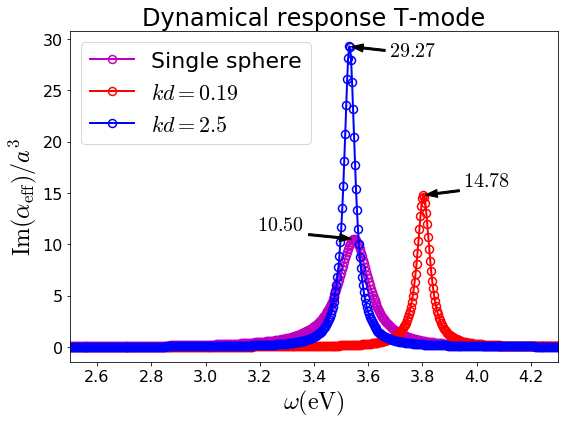

In [17]:
lat = square
d = 75*nm
a_o_d = 1.0/3.0
a = d*a_o_d

# Frequency range
nw = 501
w_min, w_max = 2.5, 4.3
ws = np.linspace(w_min, w_max, nw)
kws = ev2kw(ws, d)*twopi

# Lattice sum parameters
N_2 = 50
N_3 = 25
r0 = [0, 0, 0]
E = 1*np.sqrt(np.pi/vec_norm(lat.a1)/vec_norm(lat.a2))
N_G = 5
N_R = 5

# Polarizability
pol = alpha(ws, eps_drude, a=a, a_o_d=a_o_d, 
            unit='eV', rad_corr=True)

kvec_in = [0.19, 0, 0]
kvec_out = [2.5, 0, 0]
%time beta_z_in = np.array( [ beta_z( kvec_in, kw, N_2, N_3, N_G, N_R, E, lat ) \
                             for kw in kws ] )
Mz_in = 1.0/pol - beta_z_in/d**3

%time beta_z_out = np.array( [ beta_z( kvec_out, kw, N_2, N_3, N_G, N_R, E, lat ) \
                             for kw in kws ] )
Mz_out = 1.0/pol - beta_z_out/d**3

# Resonant frequency of single sphere, in-side light-cone mode
# and out-side light-cone mode
peak_0 = np.argmax(np.imag(pol))
w0, y0 = ws[peak_0], np.imag(pol[peak_0])/a**3
peak_in = np.argmax(np.imag(1.0/Mz_in))
w0_in, y_in = ws[peak_in], np.imag(1.0/Mz_in[peak_in])/a**3
peak_out = np.argmax(np.imag(1.0/Mz_out))
w0_out, y_out = ws[peak_out], np.imag(1.0/Mz_out[peak_out])/a**3
w0_all = w0, w0_in, w0_out
print('Single sphere resonant frequency(eV): {:.4f}'.format(w0))
print('Inside-light-cone mode resonant frequency(eV): {:.4f}'.format(w0_in))
print('Outside-light-cone mode resonant frequency(eV): {:.4f}'.format(w0_out))

# Plot
marker_style = dict(linestyle='-', marker='o', \
                    markersize=8, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, clip_on=True)

plt.figure(figsize=(8,6))
plt.plot(ws, np.imag(pol)/a**3, 'm-', 
         **marker_style, label='Single sphere')
plt.plot(ws, np.imag(1.0/Mz_in)/a**3, 'r-', 
         **marker_style, label=r'$kd=0.19$')
plt.plot(ws, np.imag(1.0/Mz_out)/a**3, 'b-', 
         **marker_style, label=r'$kd=2.5$')
axes = plt.gca()
ymin, ymax = axes.get_ylim()
# for w in w0_all:
#     plt.vlines(w, ymin, ymax, color='gray', linestyles='dashed', lw=2.0)
myarrow = dict(facecolor='black', width=2, headwidth=8, shrink=0.05)
plt.annotate('${:.2f}$'.format(y0), 
             xy=(w0,y0), xycoords='data',
             xytext=(-50,5), textcoords='offset points',
             arrowprops=myarrow,
             horizontalalignment='right', verticalalignment='bottom',
             fontsize=20)
plt.annotate('${:.2f}$'.format(y_in), 
             xy=(w0_in,y_in), xycoords='data',
             xytext=(40,5), textcoords='offset points',
             arrowprops=myarrow,
             horizontalalignment='left', verticalalignment='bottom',
             fontsize=20)
plt.annotate('${:.2f}$'.format(y_out), 
             xy=(w0_out,y_out), xycoords='data',
             xytext=(40,5), textcoords='offset points',
             arrowprops=myarrow,
             horizontalalignment='left', verticalalignment='top',
             fontsize=20)
plt.xlim(ws[0], ws[-1])
plt.ylim(ymin, ymax)
plt.xlabel(r'$\omega(\mathrm{eV})$')
plt.ylabel(r'$\mathrm{Im}(\alpha_{\mathrm{eff}})/a^3$')
plt.legend(loc='best', fontsize=22)
plt.title('Dynamical response T-mode')
plt.tight_layout()
plt.savefig('T-mode-in-out-lightcone.pdf')
plt.show()

#### $\Gamma-X$ dispersion

CPU times: user 3min 49s, sys: 6min 54s, total: 10min 44s
Wall time: 1min 23s


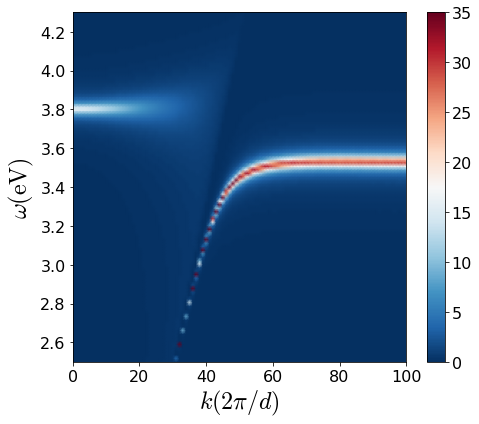

In [10]:
lat = square
Gamma = lat.reci_vec(0, 0, 0)
X = lat.reci_vec(0.5, 0, 0)
d = 75*nm
a_o_d = 1.0/3.0
a = d*a_o_d
nk = 101
nw = 101
w_min, w_max = 2.5, 4.3
ws = np.linspace(w_min, w_max, nw)
kws = ev2kw(ws, d)*twopi

kmesh = kpath(Gamma, X, nk, end_point=True)
ks = np.arange(nk)
kgrid, wgrid = np.meshgrid( ks, ws )

N_2, N_3 = 50, 25
r0 = [0, 0, 0]
E = 1*np.sqrt(np.pi/vec_norm(lat.a1)/vec_norm(lat.a2))
N_G = 5
N_R = 5
pols = alpha(ws, eps_drude, a=a, a_o_d=a_o_d, 
             unit='eV', rad_corr=True)
%time beta_zz = np.array( [ [ beta_z( kvec, kw, N_2, N_3, N_G, N_R, E, lat ) \
                             for kw in kws ] for kvec in kmesh] )

Mz = 1.0/pols - beta_zz/d**3

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
alpha_eff = 1.0 / Mz / a**3
Z = np.imag(alpha_eff.T)
im = ax.pcolormesh(kgrid, wgrid, Z, 
                   vmin = 0, vmax = 35,
                   cmap='RdBu_r', shading='gouraud')
fig.colorbar(im)
plt.xlabel(r'$k(2\pi/d)$')
plt.ylabel(r'$\omega(\mathrm{eV})$')
plt.tight_layout()
plt.savefig('T-mode-dynamical.pdf')
plt.show()

### In-plane Mode$\newcommand{\kw}{k_{\omega}}$
$$
\beta_{ii} = 3 S_3^{ii} - 3 i\kw S_2^{ii} - \kw^2 S_1^{ii} + \beta_z, \\
\beta_{ij} = 3 S_3^{ij} - 3 i\kw S_2^{ij} - \kw^2 S_1^{ij}
$$

In [18]:
# fR3yx = lambda Rvec: fnRij(Rvec, 3, 1, 0)
# fR3xx = lambda Rvec: fnRij(Rvec, 3, 0, 0)
# fR3yy = lambda Rvec: fnRij(Rvec, 3, 1, 1)

def beta_ij( i, j, kvec, kw, N_2_direct, N_3_direct, N_G, N_R, E, lat ):
    fR2ij = lambda Rvec: fnRij(Rvec, 2, i, j)
    fR3ij = lambda Rvec: fnRij(Rvec, 3, i, j)
    r0 = [0, 0, 0]
    s1 = S_ewald(kvec, kw, N_G, N_R, E, lat, 1, 1, 1) # s1_ij need to be solved!
    s2 = Rsum_direct(fR2ij, N_2_direct, r0, kvec, kw, lat)
    s3 = Rsum_direct(fR3ij, N_3_direct, r0, kvec, kw, lat)
    beta = 3*s3 - 3*1j*kw*s2 - kw**2*s1
    if i == j:
        beta_zz = beta_z( kvec, kw, N_2_direct, N_3_direct, \
                         N_G, N_R, E, lat )
        beta = beta + beta_zz
    return beta

def beta_matrix( kvec, kw, N_2_direct, N_3_direct, N_G, N_R, E, lat ):
    m11 = beta_ij( 0, 0, kvec, kw, N_2_direct, N_3_direct, N_G, N_R, E, lat)
    m12 = beta_ij( 0, 1, kvec, kw, N_2_direct, N_3_direct, N_G, N_R, E, lat)
    m21 = m12
    m22 = beta_ij( 1, 1, kvec, kw, N_2_direct, N_3_direct, N_G, N_R, E, lat)
    return np.array( [ [ m11, m12 ], [ m21, m22 ] ] )

CPU times: user 24.4 s, sys: 43.6 s, total: 1min 7s
Wall time: 8.74 s


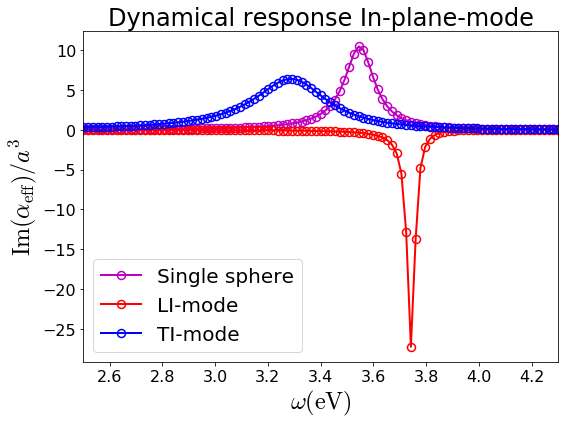

In [57]:
lat = square
kvec = [2.5, 0, 0]
nw = 101
w_min, w_max = 2.5, 4.3
ws = np.linspace(w_min, w_max, nw)
kws = ev2kw(ws, d)*twopi

N_2_direct = 100
N_3_direct = 50
N_G, N_R = 5, 5
E = 1*np.sqrt(np.pi/vec_norm(lat.a1)/vec_norm(lat.a2))

d = 75*nm
a_o_d = 1.0/3.0
a = d*a_o_d
pols = alpha(ws, eps_drude, a=a, a_o_d=a_o_d, \
             unit='eV', rad_corr=True)

%time beta = [ beta_matrix( kvec, kw, N_2_direct, N_3_direct, \
                           N_G, N_R, E, lat ) \
              for kw in kws ]
m_eig_1, m_eig_2 = np.linalg.eigvals( beta ).T

w1 = 1.0/( 1.0/pols - m_eig_1/d**3 )/a**3
w2 = 1.0/( 1.0/pols - m_eig_2/d**3 )/a**3

# Plot
marker_style = dict(linestyle='-', marker='o', \
                    markersize=8, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, clip_on=True)

plt.figure(figsize=(8,6))
plt.plot(ws, np.imag(pols)/a**3, 'm-', \
         **marker_style, label='Single sphere')
plt.plot(ws, np.imag(w1), 'ro-', \
         **marker_style, label=r'LI-mode')
plt.plot(ws, np.imag(w2), 'bo-', \
         **marker_style, label=r'TI-mode')
# myarrow = dict(facecolor='black', width=2, headwidth=8, shrink=0.05)
# plt.annotate('${:.2f}$'.format(y0), 
#              xy=(w0,y0), xycoords='data',
#              xytext=(-50,5), textcoords='offset points',
#              arrowprops=myarrow,
#              horizontalalignment='right', verticalalignment='bottom',
#              fontsize=20)
# plt.annotate('${:.2f}$'.format(y_in), 
#              xy=(w0_in,y_in), xycoords='data',
#              xytext=(40,5), textcoords='offset points',
#              arrowprops=myarrow,
#              horizontalalignment='left', verticalalignment='bottom',
#              fontsize=20)
# plt.annotate('${:.2f}$'.format(y_out), 
#              xy=(w0_out,y_out), xycoords='data',
#              xytext=(40,5), textcoords='offset points',
#              arrowprops=myarrow,
#              horizontalalignment='left', verticalalignment='top',
#              fontsize=20)
plt.xlim(ws[0], ws[-1])
plt.xlabel(r'$\omega(\mathrm{eV})$')
plt.ylabel(r'$\mathrm{Im}(\alpha_{\mathrm{eff}})/a^3$')
plt.legend(loc='best', fontsize=20)
plt.title('Dynamical response In-plane-mode')
plt.tight_layout()
plt.savefig('Inplane-mode-outside-light-cone.pdf')
plt.show()

In [56]:
mat1 = beta[0]
mat2 = np.mat( beta[0] )
print(mat1)
print(mat2)

[[-6.27843441-1.75128075j -0.23998801+0.85445061j]
 [-0.23998801+0.85445061j  6.89057095+1.46594935j]]
[[-6.27843441-1.75128075j -0.23998801+0.85445061j]
 [-0.23998801+0.85445061j  6.89057095+1.46594935j]]


### $\Gamma-X$ dispersion

In [ ]:
lat = square
Gamma = lat.reci_vec(0, 0, 0)
X = lat.reci_vec(0.5, 0, 0)
d = 75*nm
a_o_d = 1.0/3.0
a = d*a_o_d
nk = 101
nw = 101
w_min, w_max = 2.5, 4.3
ws = np.linspace(w_min, w_max, nw)
kws = ev2kw(ws, d)*twopi

kmesh = kpath(Gamma, X, nk, end_point=True)
ks = np.arange(nk)
kgrid, wgrid = np.meshgrid( ks, ws )

N_2, N_3 = 100, 50
r0 = [0, 0, 0]
E = 1*np.sqrt(np.pi/vec_norm(lat.a1)/vec_norm(lat.a2))
N_G = 5
N_R = 5

pols = alpha(ws, eps_drude, a=a, a_o_d=a_o_d, 
             unit='eV', rad_corr=True)
%time beta = [ beta_matrix( kvec, kw, N_2_direct, N_3_direct, \
                         N_G, N_R, E, lat )
m_eig_1, m_eig_2 = np.linalg.eigvals( beta ).T

w1 = 1.0/( 1.0/pols - m_eig_1/d**3 )/a**3
w2 = 1.0/( 1.0/pols - m_eig_2/d**3 )/a**3

%time beta_zz = np.array( [ [ beta_z( kvec, kw, N_2, N_3, N_G, N_R, E, lat ) \
                             for kw in kws ] for kvec in kmesh] )

Mz = 1.0/pols - beta_zz/d**3

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
alpha_eff = 1.0 / Mz / a**3
Z = np.imag(alpha_eff.T)
im = ax.pcolormesh(kgrid, wgrid, Z, 
                   vmin = 0, vmax = 35,
                   cmap='RdBu_r', shading='gouraud')
fig.colorbar(im)
plt.xlabel(r'$k(2\pi/d)$')
plt.ylabel(r'$\omega(\mathrm{eV})$')
plt.tight_layout()
plt.savefig('T-mode-dynamical.pdf')
plt.show()

CPU times: user 3.32 s, sys: 2.5 s, total: 5.81 s
Wall time: 3.09 s
CPU times: user 3.38 s, sys: 2.25 s, total: 5.63 s
Wall time: 2.92 s
CPU times: user 3.38 s, sys: 2.34 s, total: 5.72 s
Wall time: 2.94 s


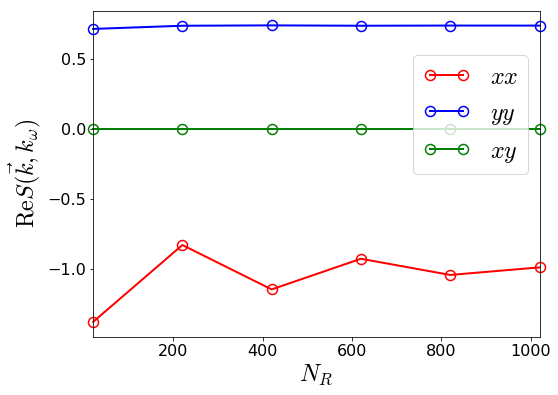

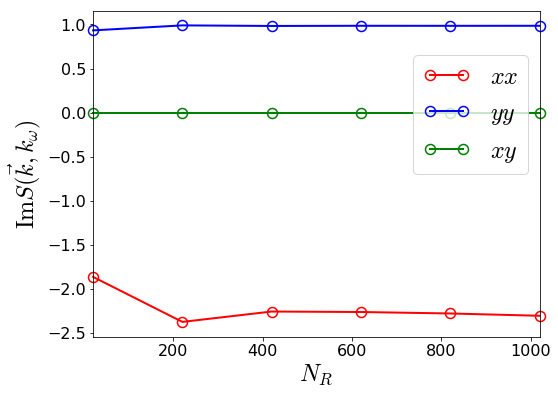

In [62]:
fR1xx = lambda Rvec: fnRij(Rvec, 1, 0, 0)
fR1xy = lambda Rvec: fnRij(Rvec, 1, 0, 1)
fR1yy = lambda Rvec: fnRij(Rvec, 1, 1, 1)

# Sample calculation for xx, xy, yy  component of 1/R lattice sums
r0 = [0, 0, 0]
kvec = [2.5, 0, 0]
w = 3.4
d = 75*nm
kw = ev2kw(w, d)*twopi
lat_test = square
nums = np.arange(20, 1200, 200)

%time f1xx = [ Rsum_direct(fR1xx, numR, r0, kvec, kw, lat_test) \
              for numR in nums ]
%time f1xy = [ Rsum_direct(fR1xy, numR, r0, kvec, kw, lat_test) \
              for numR in nums ]
%time f1yy = [ Rsum_direct(fR1yy, numR, r0, kvec, kw, lat_test) \
              for numR in nums ]

marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=False)

plt.figure(figsize=(8,6))
plt.plot(nums, np.real(f1xx), 'ro-', label=r'$xx$', \
        **marker_style)
plt.plot(nums, np.real(f1yy), 'bo-', label=r'$yy$', \
        **marker_style)
plt.plot(nums, np.real(f1xy), 'go-', label=r'$xy$', \
        **marker_style)
plt.xlim((nums[0], nums[-1]))
plt.xlabel('$N_R$')
plt.ylabel(r'$\mathrm{Re}S(\vec{k}, k_{\omega})$')
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.9),\
           numpoints=2, fontsize=24)
# plt.tight_layout()
# plt.savefig('direct-R1ij-sum-real.pdf')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(nums, np.imag(f1xx), 'ro-', label=r'$xx$', \
        **marker_style)
plt.plot(nums, np.imag(f1yy), 'bo-', label=r'$yy$', \
        **marker_style)
plt.plot(nums, np.imag(f1xy), 'go-', label=r'$xy$', \
        **marker_style)
plt.xlim((nums[0], nums[-1]))
plt.xlabel('$N_R$')
plt.ylabel(r'$\mathrm{Im}S(\vec{k}, k_{\omega})$')
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.9),\
           numpoints=2, fontsize=24)
# plt.tight_layout()
# plt.savefig('direct-R1ij-sum-imag.pdf')
plt.show()

In [63]:
f1xy[0]

(-2.7755575615628914e-16-1.1102230246251565e-16j)